# CSC-345: Object Recognition Report 
2112325

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.feature
from IPython.display import clear_output
import gc
import multiprocessing
import csv
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
import seaborn as sns
import pandas as pd 


In [2]:
trainingImages = np.load('trnImage.npy')
testingImages = np.load('tstImage.npy')

In [3]:
print(trainingImages.shape)

(32, 32, 3, 50000)


# Data Initialisation (Avoid running,load npy files instead)
This is where data is initialised using hog. It is applied in one batch and stored as two numpy files due to the large computational requirement. It is then reloaded any time it is needed.

In [4]:
# Extract features from a single image
def prepareImages(images,split):
    
    splitData = np.array_split(images, split, axis=3)
    number_of_elements = images.shape[3]
    
    hog_feature = skimage.feature.hog(splitData[0][:, :, :, 0], pixels_per_cell=[2,2], cells_per_block=[3,3],channel_axis = 2)
    #hogFeatures = np.empty([number_of_elements],dtype=Common_DataType)
    hogFeatures = [0]*number_of_elements 
    
    for n in range(0,split):
        curMax = splitData[n].shape[3]
        for i in range(curMax):
            hog_feature = skimage.feature.hog(splitData[n][:, :, :, i], pixels_per_cell=[2,2], cells_per_block=[3,3],channel_axis = 2)
            hogFeatures[i+(n*curMax)] = hog_feature
            update_progress(i / curMax,i,curMax,split,n)

        update_progress(1,curMax,curMax,split,n+1)
    return hogFeatures

def update_progress(progress,cur,max,splitPerc,n):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}% : ({2}/{3}), ({5}/{4})".format( "#" * block + "-" * (bar_length - block), progress * 100,cur,max,splitPerc,n)
    print(text)


In [5]:
gc.disable()
with multiprocessing.Pool(8) as pool:
    testingData = prepareImages(testingImages,100)  
gc.enable()

Progress: [####################] 100.0% : (100/100), (100/100)


In [6]:
gc.disable()
with multiprocessing.Pool(8) as pool:
    trainingData = prepareImages(trainingImages,100)  
gc.enable()


Progress: [####################] 100.0% : (500/500), (100/100)


In [7]:
np.save('tstData.npy', testingData)
np.save('trnData.npy', trainingData)


# Neural Netowrk Code

In [88]:
tstData = np.load('tstData.npy',allow_pickle=True)
trnData = np.load('trnData.npy',allow_pickle=True)

trainingLabelsCoarse = np.load('trnLabel_coarse.npy')
trainingLabelsFine = np.load('trnLabel_fine.npy')
testingLabelsCoarse = np.load('tstLabel_coarse.npy')
testingLabelsFine = np.load('tstLabel_fine.npy')

with open('coarse_labels.csv', newline='') as f:
  reader = csv.reader(f)
  coarse_labels = next(reader)

with open('fine_labels.csv', newline='') as f:
  reader = csv.reader(f)
  fine_labels = next(reader)

In [149]:
def confussionMatrixO(tstData,testingLabels, labels,model):
    predictions = model.predict(tstData)
    predicted_classes = np.argmax(predictions, axis=1)

    n = len(labels)
    cm = confusion_matrix(testingLabels, predicted_classes)
    cm = pd.DataFrame(cm, labels, labels)
    
    return cm

In [141]:
modelCrsNN = tf.keras.Sequential(layers=[
    layers.Dense(128, activation=tf.nn.relu),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(32, activation=tf.nn.relu),
    layers.Dropout(0.3),
    layers.Dense(len(np.unique(trainingLabelsCoarse)), activation=tf.nn.softmax)])

modelFineNN = tf.keras.Sequential(layers=[
    layers.Dense(128, activation=tf.nn.relu),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dropout(0.25),
    layers.Dense(32, activation=tf.nn.relu),
    layers.Dense(len(np.unique(trainingLabelsFine)), activation=tf.nn.softmax)])


In [142]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

modelCrsNN.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

modelFineNN.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())



In [143]:
historyCrsNN = modelCrsNN.fit(trnData, trainingLabelsCoarse, epochs=15, validation_split=0.2, verbose=0, callbacks =[early_stopping])
modelCrsNN.summary()

historyFineNN = modelFineNN.fit(trnData, trainingLabelsFine, epochs=15, validation_split=0.2, verbose=0, callbacks =[early_stopping])
modelFineNN.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_126 (Dense)           (None, 128)               2032256   
                                                                 
 dense_127 (Dense)           (None, 64)                8256      
                                                                 
 dense_128 (Dense)           (None, 64)                4160      
                                                                 
 dense_129 (Dense)           (None, 32)                2080      
                                                                 
 dropout_20 (Dropout)        (None, 32)                0         
                                                                 
 dense_130 (Dense)           (None, 20)                660       
                                                                 
Total params: 2047412 (7.81 MB)
Trainable params: 204

In [144]:
result = modelCrsNN.evaluate(tstData, testingLabelsCoarse)
resultsFineNN = modelFineNN.evaluate(tstData, testingLabelsFine)


313/313 [==============================] - 1s 2ms/step - loss: 3.6448 - sparse_categorical_accuracy: 0.1649


# Neural Network Graphing
Relevant graphs for the model are created here including the confusion matrix

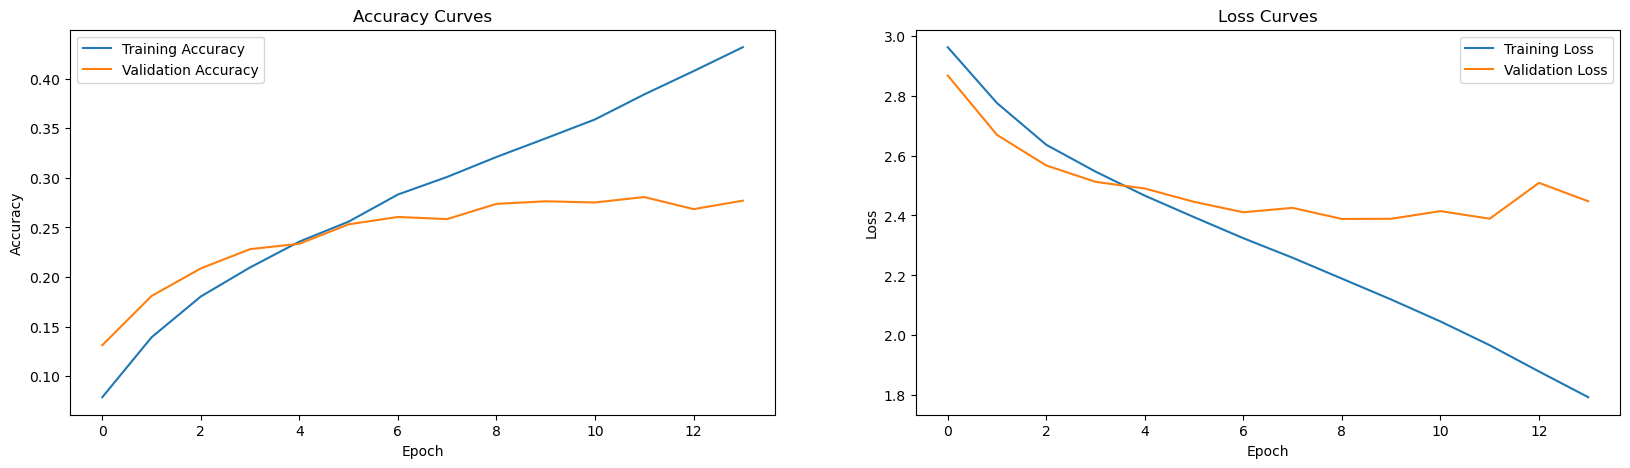

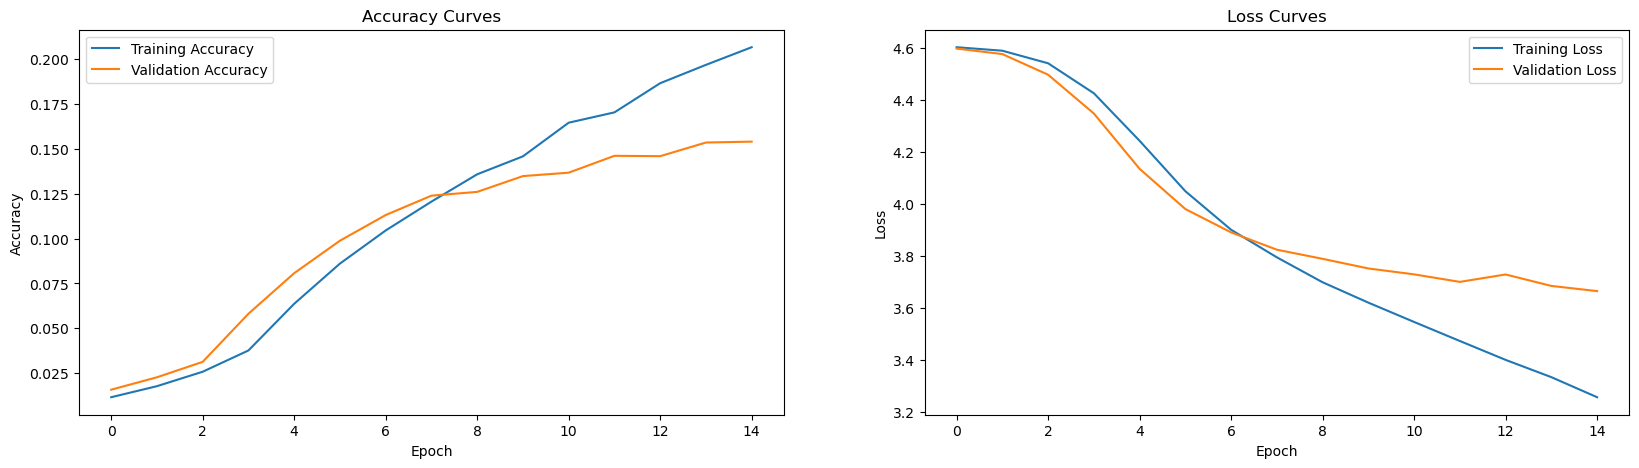

In [145]:
plt.figure(figsize=[20,5])
plt.subplot(121)
plt.plot(historyCrsNN.history['sparse_categorical_accuracy'])
plt.plot(historyCrsNN.history['val_sparse_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy',
           'Validation Accuracy'])
plt.title('Accuracy Curves')

plt.subplot(122)
plt.plot(historyCrsNN.history['loss'])
plt.plot(historyCrsNN.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])

plt.title('Loss Curves')
plt.show()

plt.figure(figsize=[20,5])

plt.subplot(121)
plt.plot(historyFineNN.history['sparse_categorical_accuracy'])
plt.plot(historyFineNN.history['val_sparse_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy',
           'Validation Accuracy'])
plt.title('Accuracy Curves')

plt.subplot(122)
plt.plot(historyFineNN.history['loss'])
plt.plot(historyFineNN.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])

plt.title('Loss Curves')
plt.show()

313/313 [==============================] - 1s 2ms/step


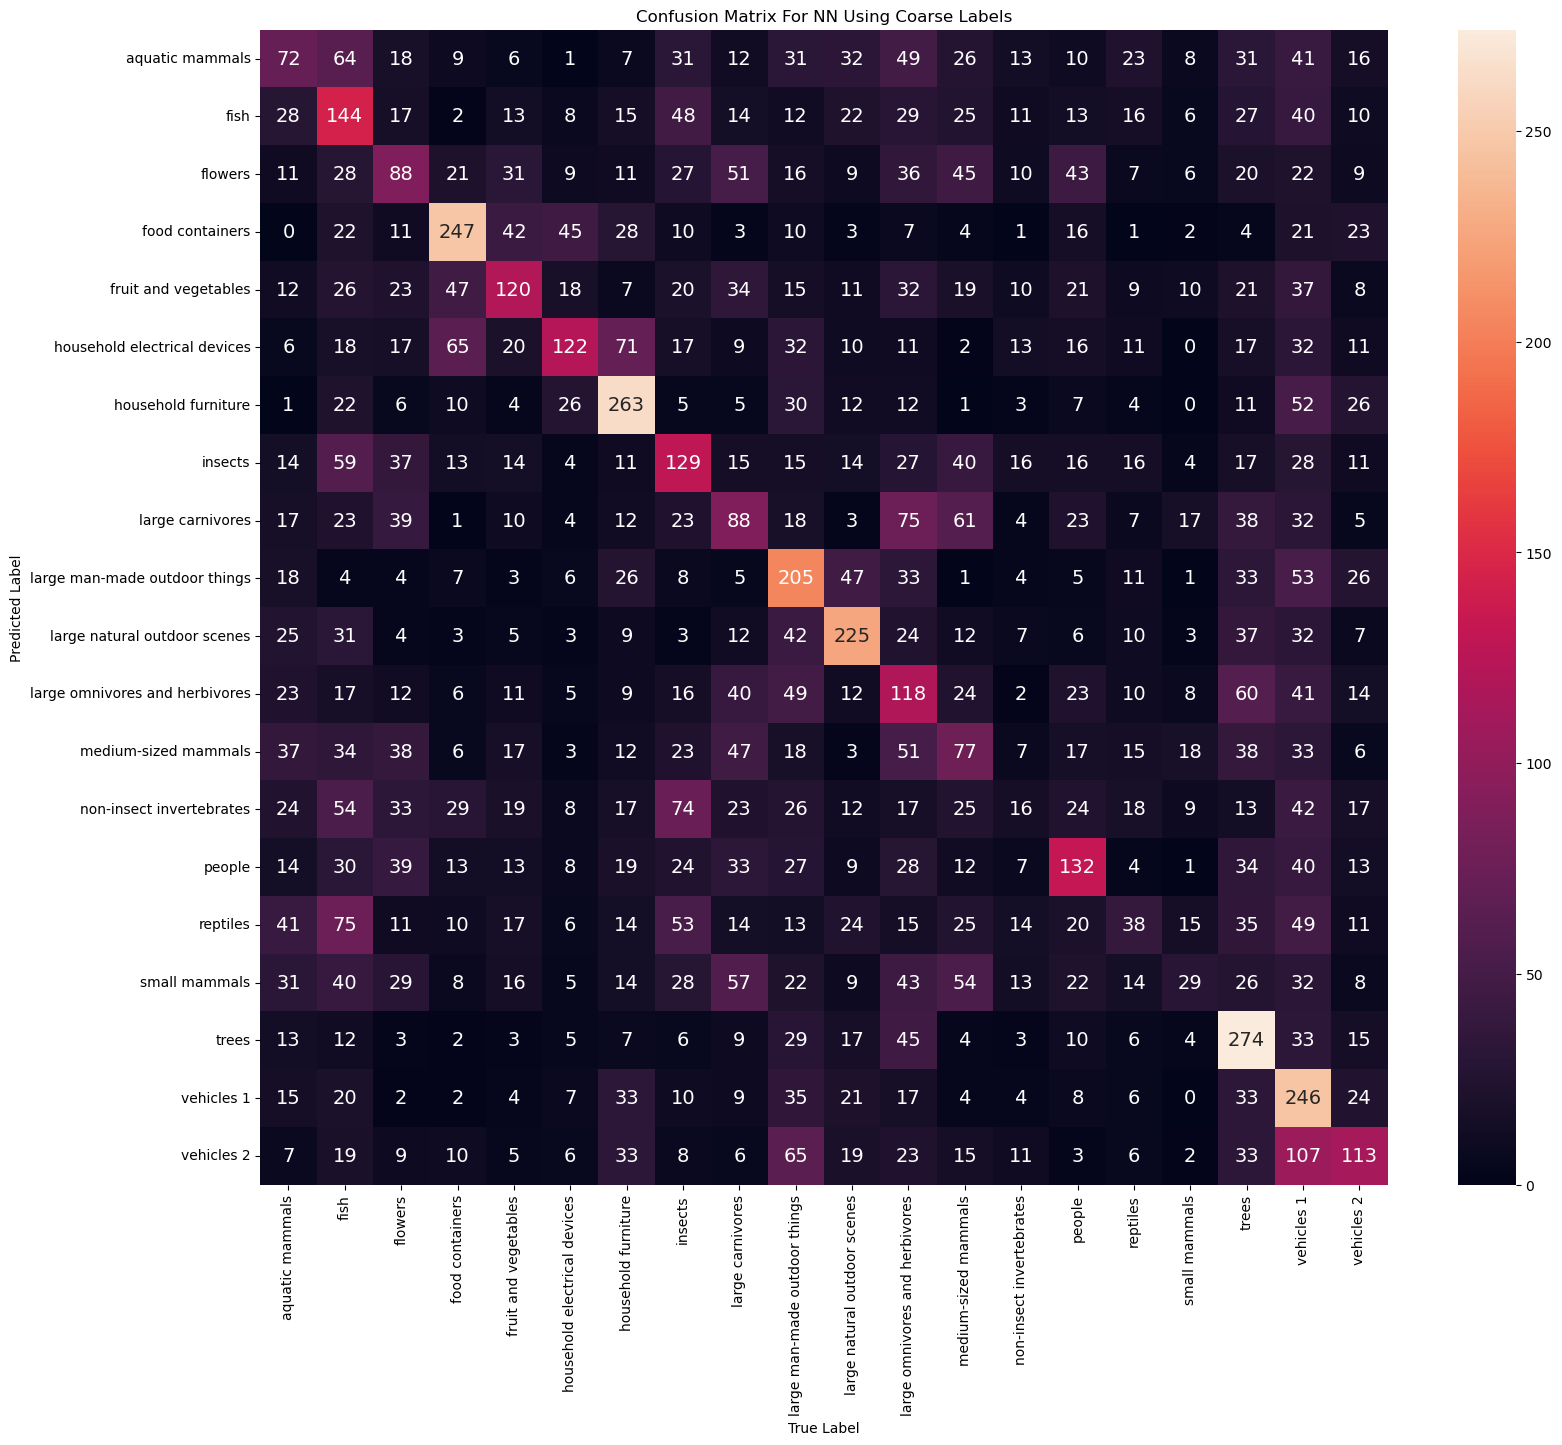

In [150]:
cmCoarse = confussionMatrixO(tstData, testingLabelsCoarse, coarse_labels,modelCrsNN)
plt.figure(figsize = (40,15))
plt.subplot(121)
sns.heatmap(cmCoarse, annot=True, annot_kws={"size":14},fmt ='g') # font size
plt.xlabel('True Label')
plt.ylabel('Predicted Label')

plt.title('Confusion Matrix For NN Using Coarse Labels')
plt.show()

313/313 [==============================] - 1s 2ms/step


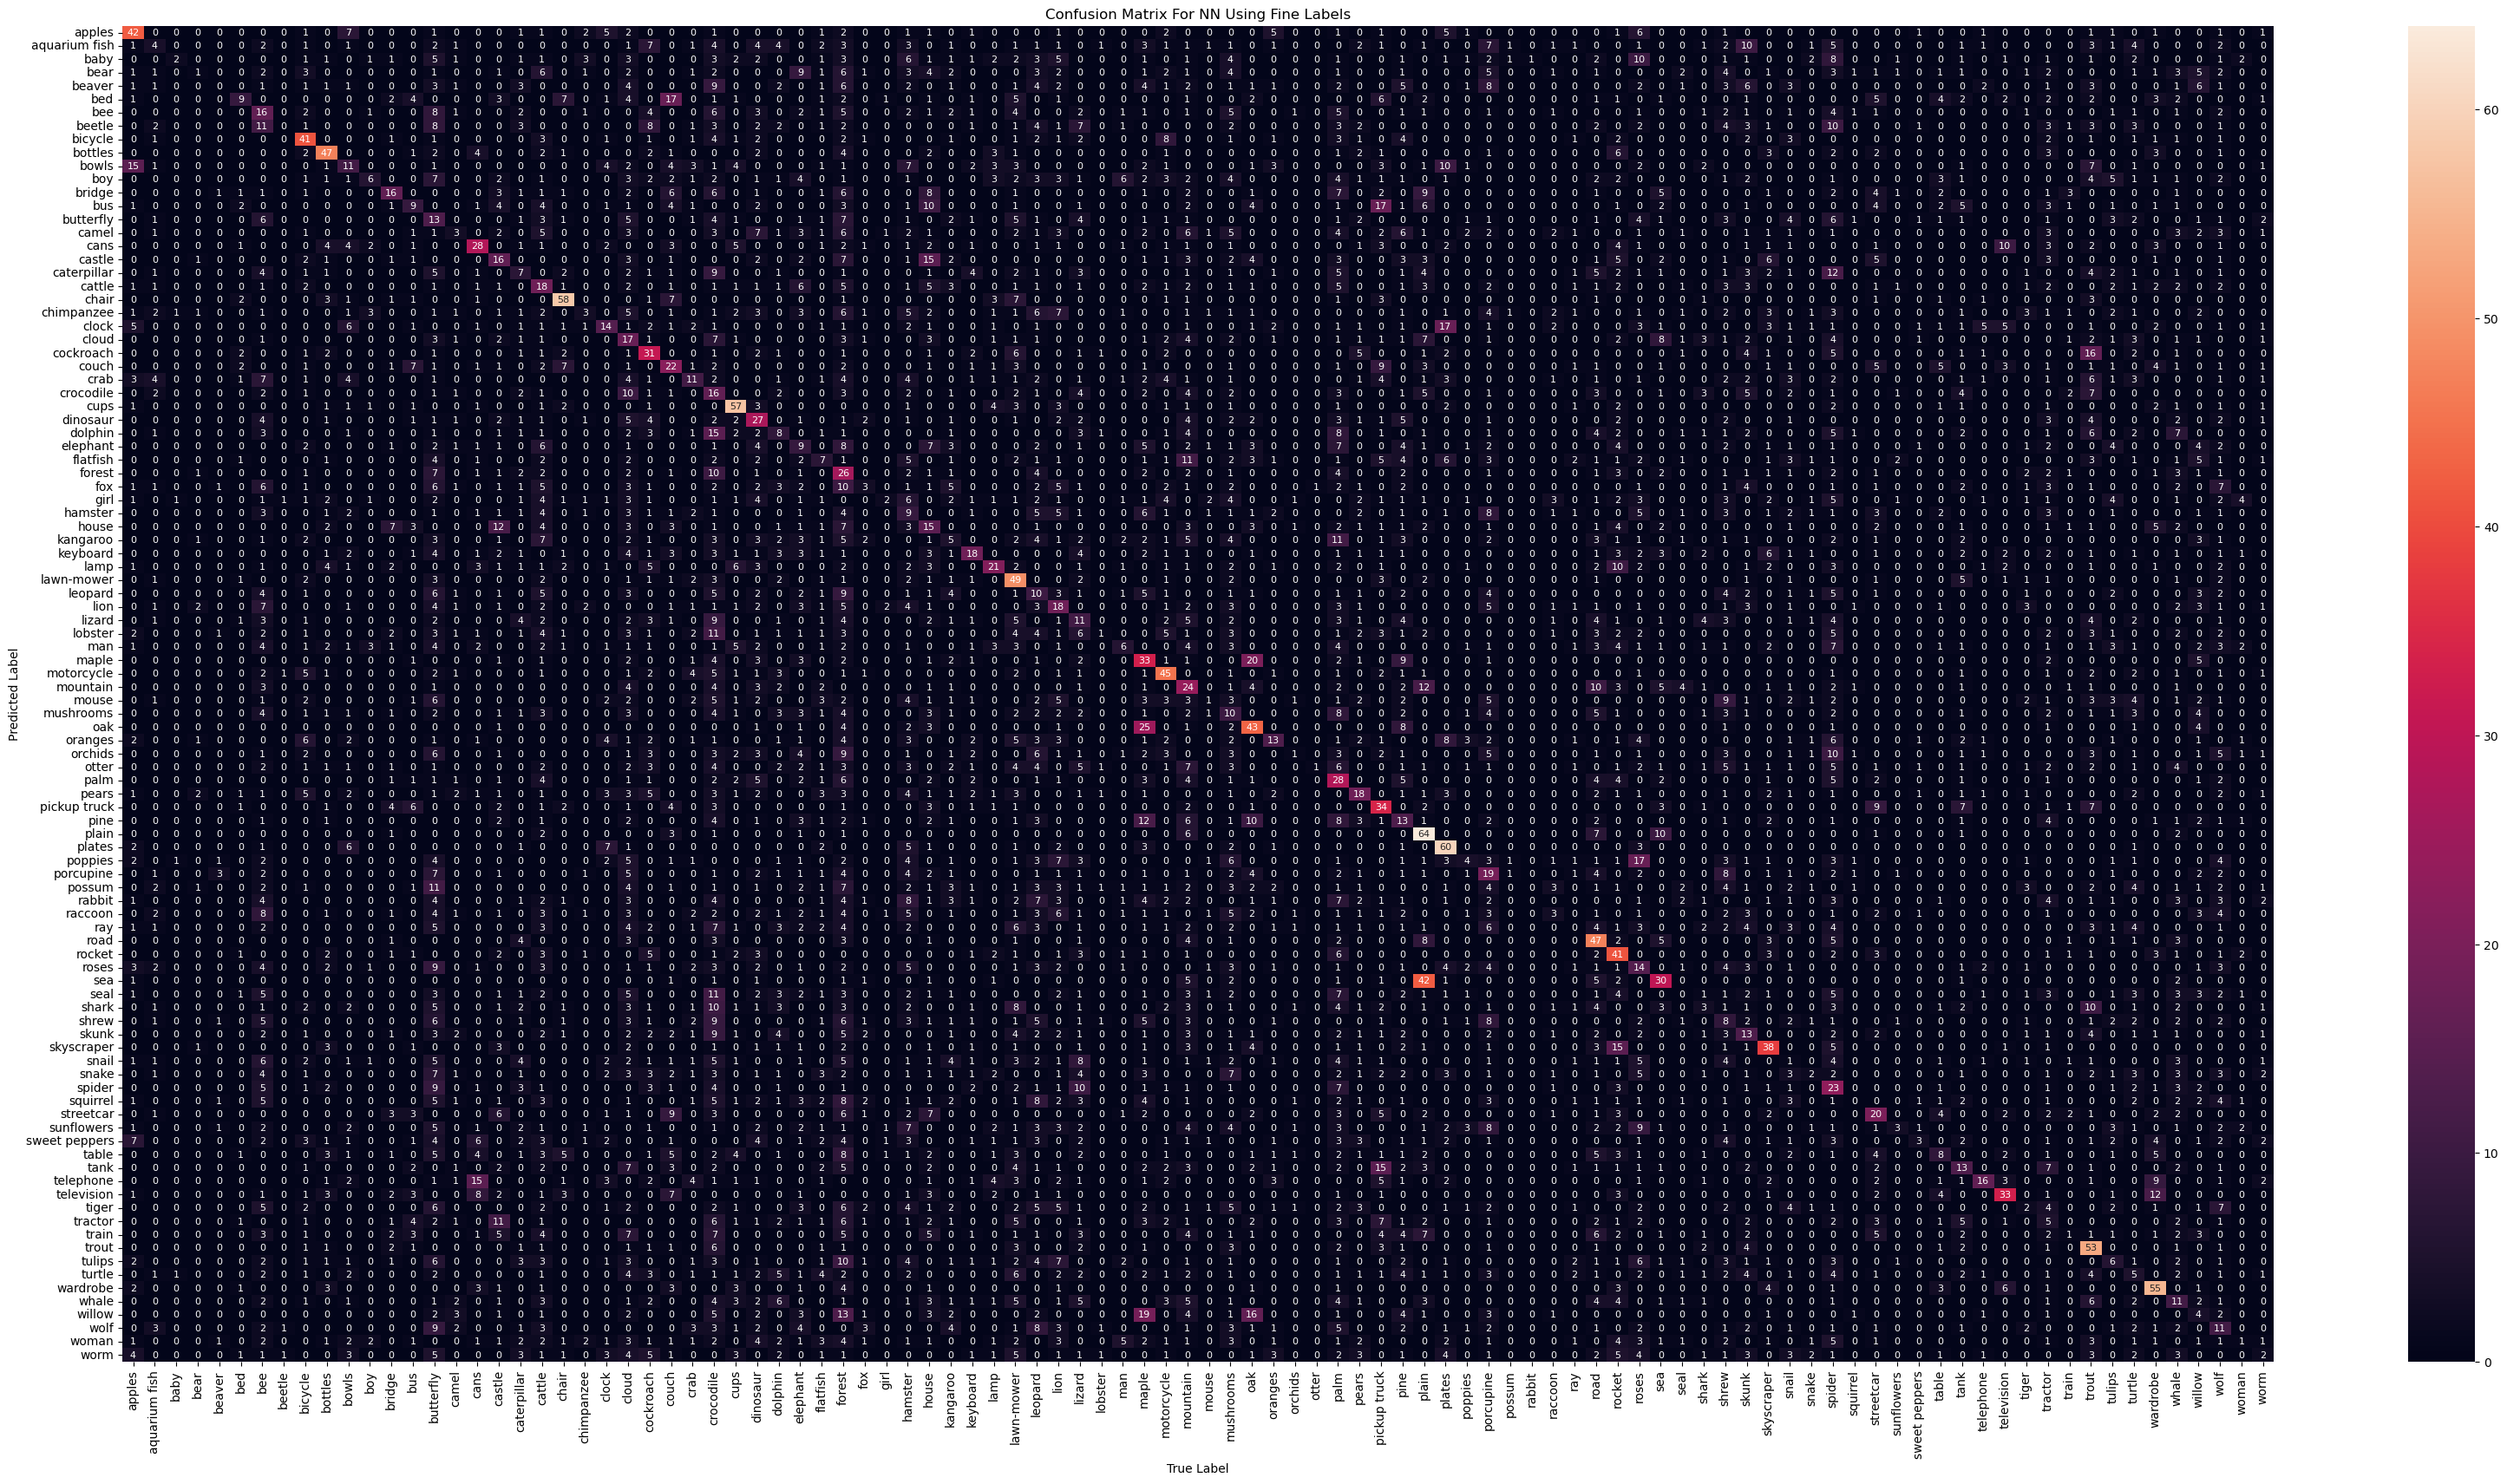

In [151]:
cmFine = confussionMatrixO(tstData, testingLabelsFine, fine_labels,modelFineNN)
plt.figure(figsize = (40,20))
sns.heatmap(cmFine, annot=True, annot_kws={"size":8},fmt ='g') # font size
plt.xlabel('True Label')
plt.ylabel('Predicted Label')


plt.title('Confusion Matrix For NN Using Fine Labels')
plt.show()

# Convolutional Neural Network

In [152]:
train_images = np.load('trnImage.npy')
test_images = np.load('tstImage.npy')

trainingLabelsCoarse = np.load('trnLabel_coarse.npy')
trainingLabelsFine = np.load('trnLabel_fine.npy')
testingLabelsCoarse = np.load('tstLabel_coarse.npy')
testingLabelsFine = np.load('tstLabel_fine.npy')

with open('coarse_labels.csv', newline='') as f:
  reader = csv.reader(f)
  coarse_labels = next(reader)

with open('fine_labels.csv', newline='') as f:
  reader = csv.reader(f)
  fine_labels = next(reader)
    

train_images = np.transpose(train_images,( 3,0, 1, 2))
test_images = np.transpose(test_images, (3,0, 1, 2))

In [153]:
modelCrsCNN = models.Sequential()
modelCrsCNN.add(layers.Conv2D(32, (4, 3), activation='relu', input_shape=(32, 32, 3)))
modelCrsCNN.add(layers.MaxPooling2D((2, 2)))
modelCrsCNN.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelCrsCNN.add(layers.MaxPooling2D((2, 2)))
modelCrsCNN.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelCrsCNN.add(layers.Flatten())
modelCrsCNN.add(layers.Dense(64, activation='relu'))
modelCrsCNN.add(layers.Dense(len(coarse_labels)))
modelCrsCNN.summary()

modelFineCNN = models.Sequential()
modelFineCNN.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
modelFineCNN.add(layers.MaxPooling2D((2, 2)))
modelFineCNN.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelFineCNN.add(layers.MaxPooling2D((2, 2)))
modelFineCNN.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelFineCNN.add(layers.Flatten())
modelFineCNN.add(layers.Dense(64, activation='relu'))
modelFineCNN.add(layers.Dense(len(fine_labels)))
modelFineCNN.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 29, 30, 32)        1184      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 12, 13, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
 flatten_4 (Flatten)         (None, 1024)            

In [154]:

modelCrsCNN.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=tf.keras.metrics.SparseCategoricalAccuracy())

modelFineCNN.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())


crsCNNHistory = modelCrsCNN.fit(train_images, trainingLabelsCoarse, epochs=15, 
                    validation_data=(test_images, testingLabelsCoarse),verbose=0,
                    callbacks=[early_stopping])

fineCNNHistory = modelFineCNN.fit(train_images, trainingLabelsFine, epochs=15, 
                    validation_data=(test_images, testingLabelsFine),verbose=0,
                    callbacks=[early_stopping])


# Graphing Convolutional Neural Network 

In [155]:
resultsCourseCNN = modelCrsCNN.evaluate(test_images, testingLabelsCoarse)
print(f'Test set loss: {resultsCourseCNN[0]:0.2f}, test set accuracy: {resultsCourseCNN[1]*100:0.2f}%')

resultsFineCNN = modelFineCNN.evaluate(test_images, testingLabelsFine)
print(f'Test set loss: {resultsFineCNN[0]:0.2f}, test set accuracy: {resultsFineCNN[1]*100:0.2f}%')

313/313 [==============================] - 1s 3ms/step - loss: 1.6651 - sparse_categorical_accuracy: 0.4876
Test set loss: 1.67, test set accuracy: 48.76%
313/313 [==============================] - 1s 3ms/step - loss: 2.6088 - sparse_categorical_accuracy: 0.3451
Test set loss: 2.61, test set accuracy: 34.51%


313/313 [==============================] - 1s 3ms/step


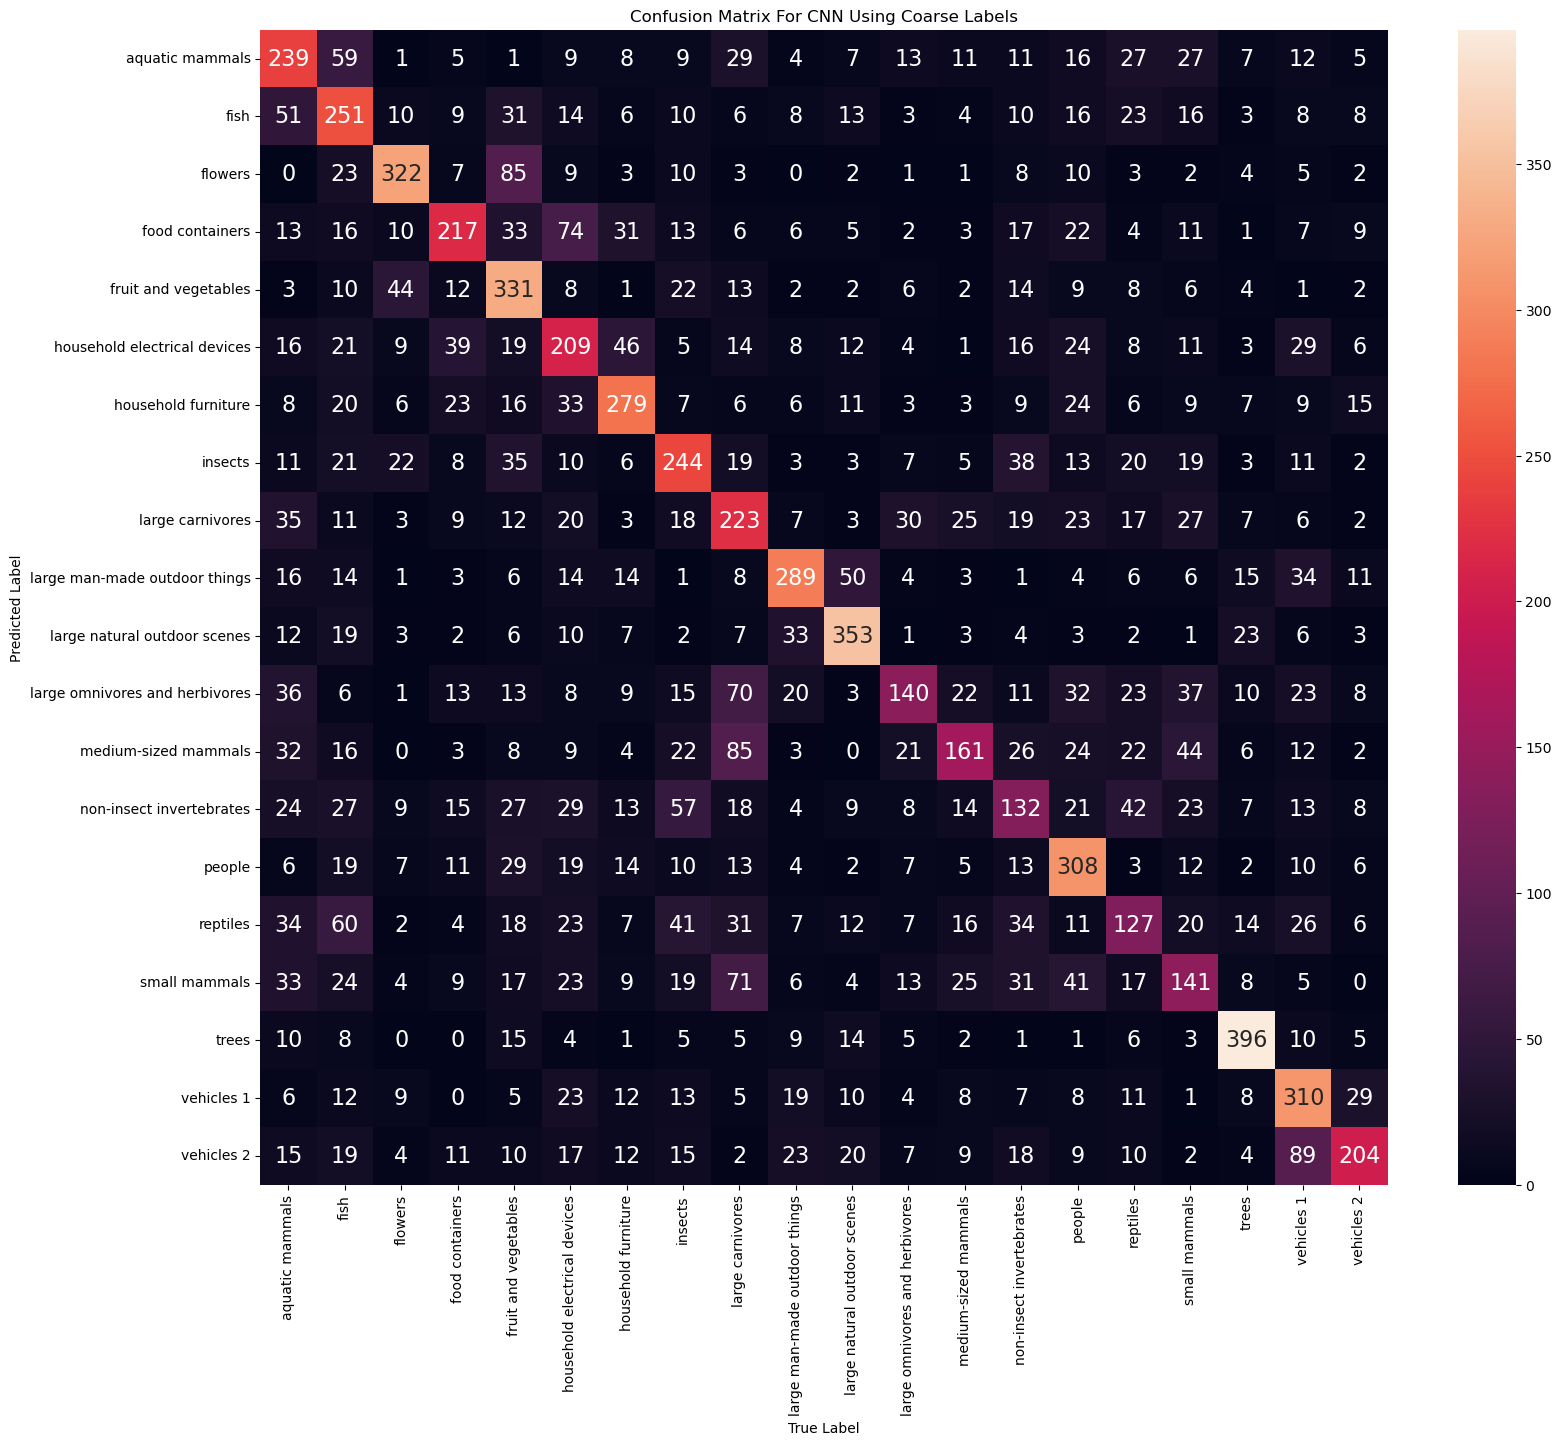

313/313 [==============================] - 1s 3ms/step


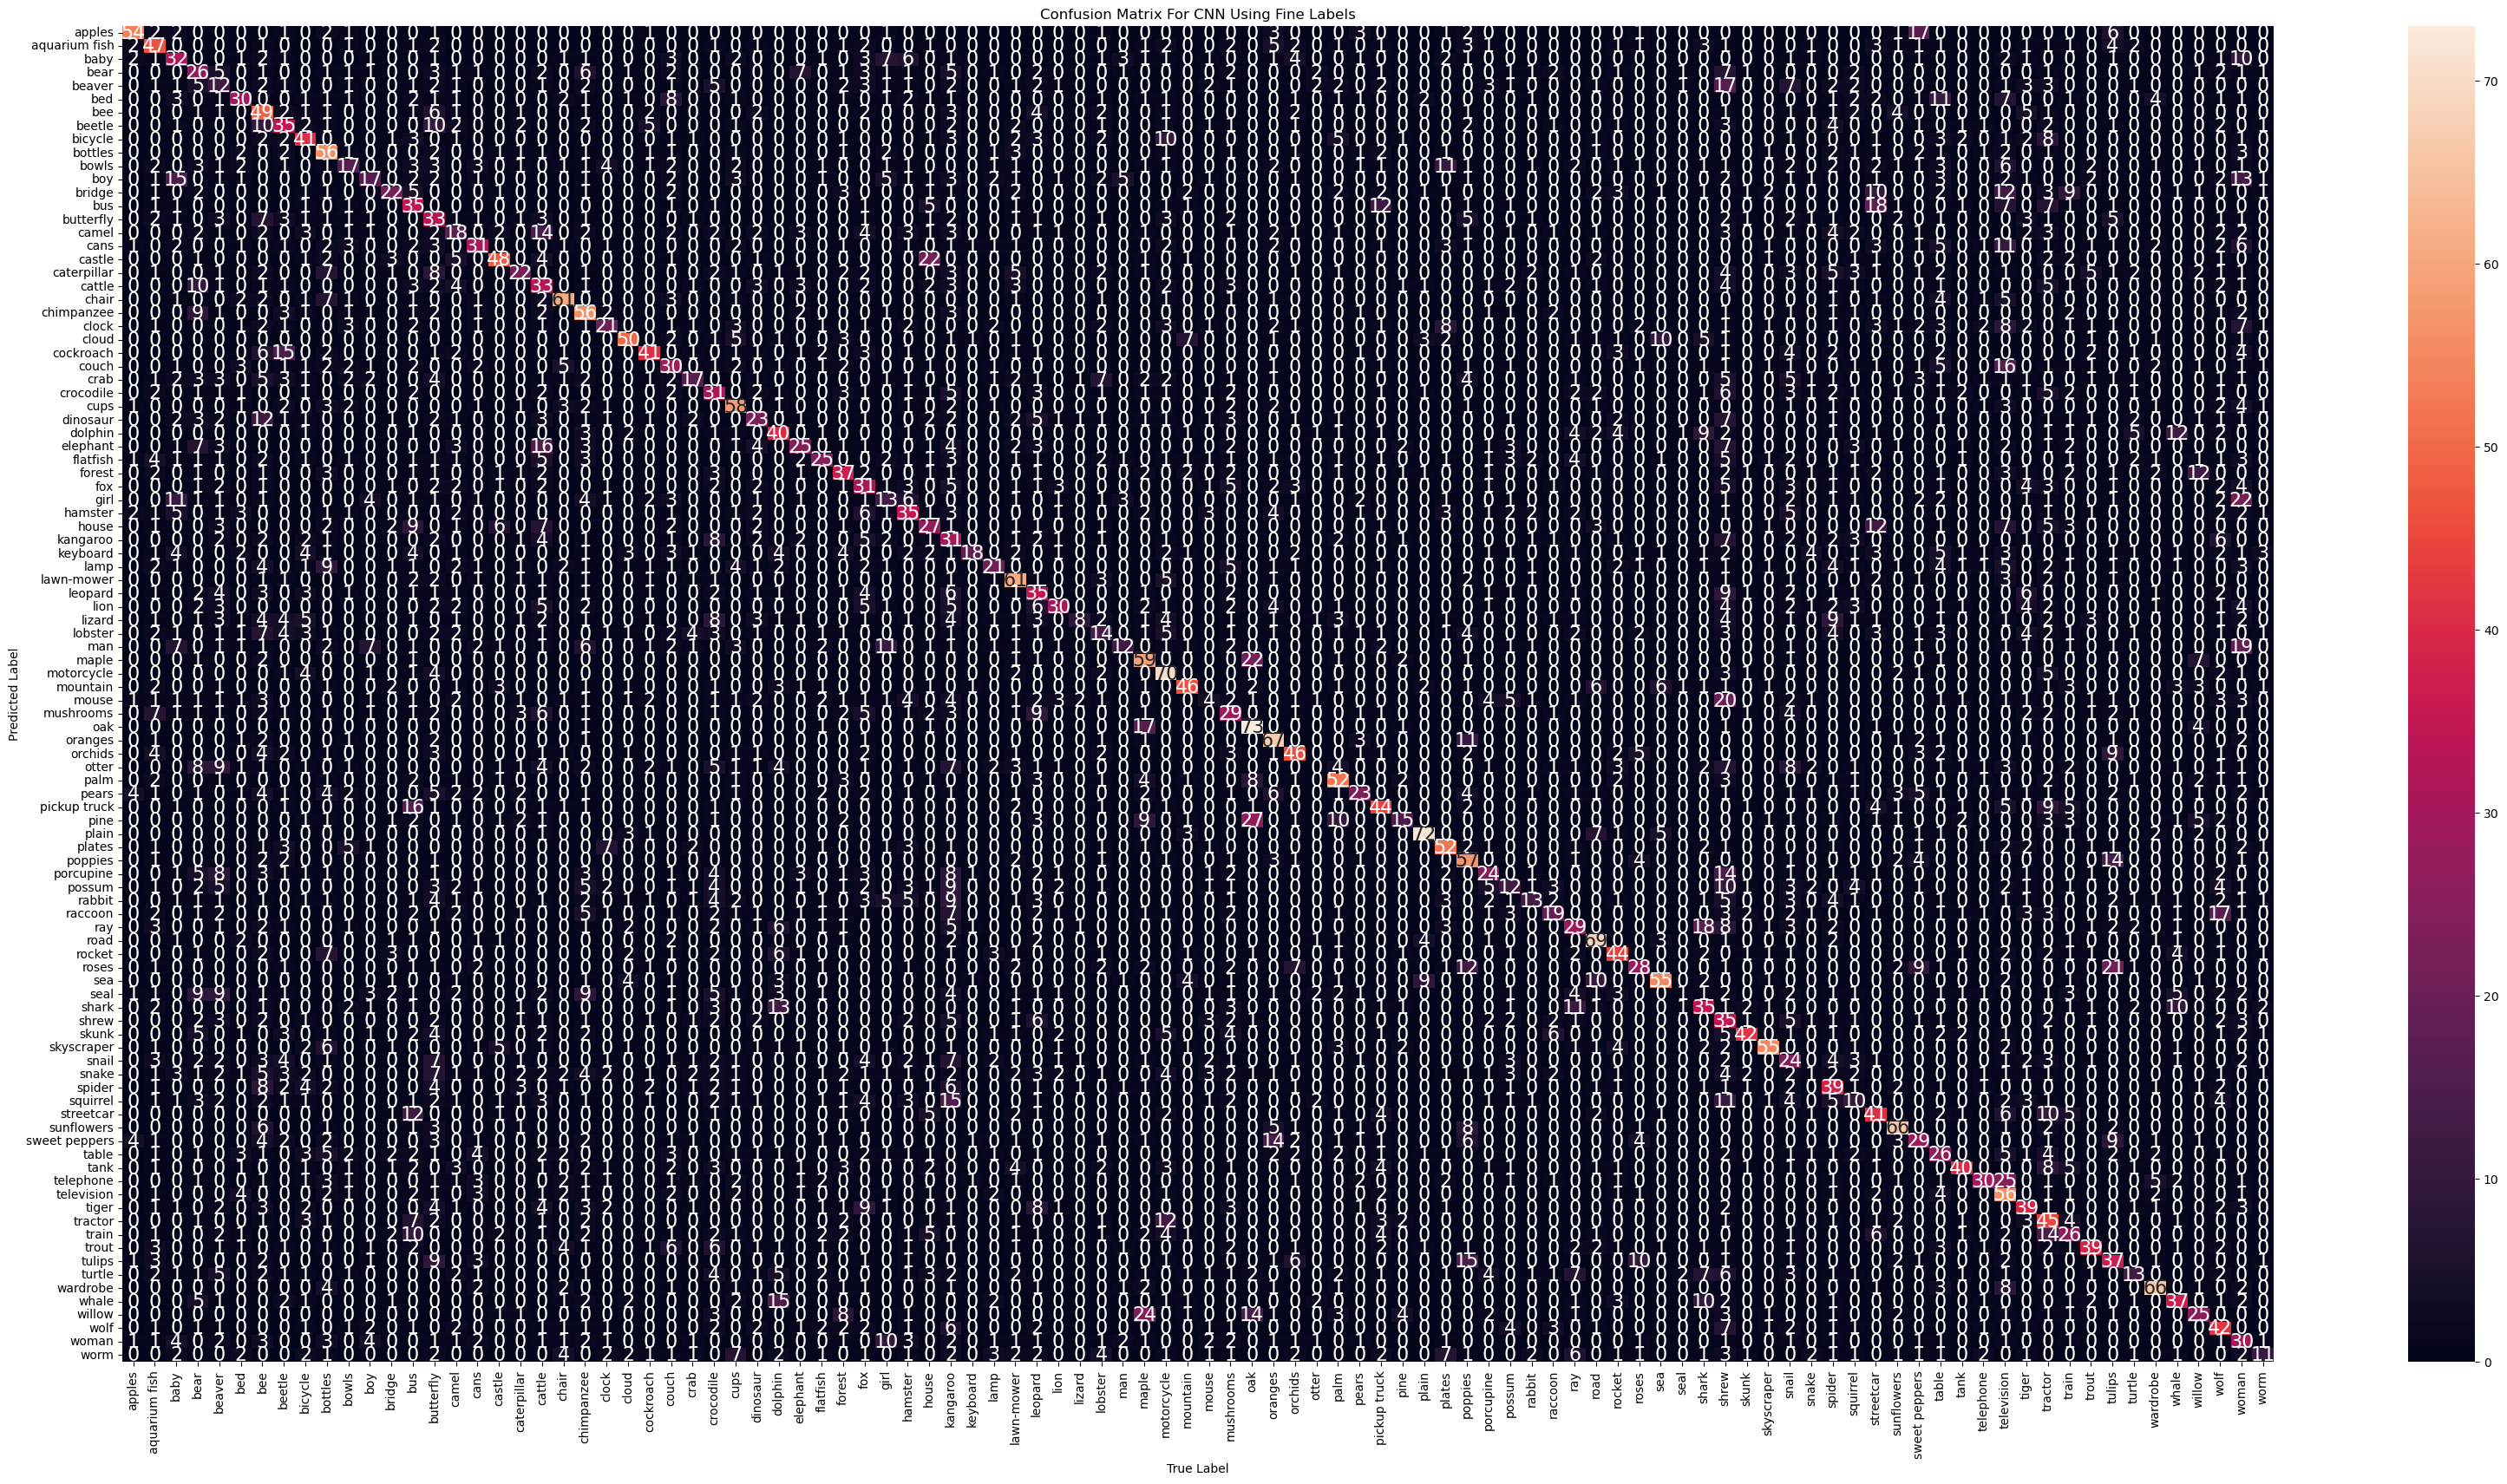

In [159]:
cmCoarse = confussionMatrixO(test_images, testingLabelsCoarse, coarse_labels,modelCrsCNN)
plt.figure(figsize = (40,15))
plt.subplot(121)
sns.heatmap(cmCoarse, annot=True, annot_kws={"size":16},fmt ='g') # font size
plt.xlabel('True Label')
plt.ylabel('Predicted Label')

plt.title('Confusion Matrix For CNN Using Coarse Labels')
plt.show()

cmFine = confussionMatrixO(test_images, testingLabelsFine, fine_labels,modelFineCNN)
plt.figure(figsize = (40,20))
sns.heatmap(cmFine, annot=True, annot_kws={"size": 16},fmt ='g') # font size
plt.xlabel('True Label')
plt.ylabel('Predicted Label')

plt.title('Confusion Matrix For CNN Using Fine Labels')
plt.show()

In [158]:
print(train_images.shape)

(50000, 32, 32, 3)
